# Load Data

In [ ]:
import polars as pl
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, brier_score_loss
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier

In [ ]:
!pip install kaggle

In [ ]:
import os
os.makedirs('/root/.kaggle', exist_ok=True)
# Use the file upload widget
from google.colab import files
files.upload()  # Upload your kaggle.json file here

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"beyzabal0","key":"91cff5f1980f29e22e2d53dcc5a1d50b"}'}

In [ ]:
!cp kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c home-credit-credit-risk-model-stability

100% 3.14G/3.14G [00:25<00:00, 307MB/s]
100% 3.14G/3.14G [00:25<00:00, 134MB/s]


In [ ]:
def set_table_dtypes(df: pl.DataFrame) -> pl.DataFrame:

    for col in df.columns:
        if col[-1] in ("P", "A"):
            df = df.with_columns(pl.col(col).cast(pl.Float64).alias(col))

    return df

def convert_strings(df: pd.DataFrame) -> pd.DataFrame:
    for col in df.columns:
        if df[col].dtype.name in ['object', 'string']:
            df[col] = df[col].astype("string").astype('category')
            current_categories = df[col].cat.categories
            new_categories = current_categories.to_list() + ["Unknown"]
            new_dtype = pd.CategoricalDtype(categories=new_categories, ordered=True)
            df[col] = df[col].astype(new_dtype)
    return df

In [ ]:
!unzip home-credit-credit-risk-model-stability.zip

Archive:  home-credit-credit-risk-model-stability.zip
  inflating: csv_files/test/test_applprev_1_0.csv  
  inflating: csv_files/test/test_applprev_1_1.csv  
  inflating: csv_files/test/test_applprev_1_2.csv  
  inflating: csv_files/test/test_applprev_2.csv  
  inflating: csv_files/test/test_base.csv  
  inflating: csv_files/test/test_credit_bureau_a_1_0.csv  
  inflating: csv_files/test/test_credit_bureau_a_1_1.csv  
  inflating: csv_files/test/test_credit_bureau_a_1_2.csv  
  inflating: csv_files/test/test_credit_bureau_a_1_3.csv  
  inflating: csv_files/test/test_credit_bureau_a_1_4.csv  
  inflating: csv_files/test/test_credit_bureau_a_2_0.csv  
  inflating: csv_files/test/test_credit_bureau_a_2_1.csv  
  inflating: csv_files/test/test_credit_bureau_a_2_10.csv  
  inflating: csv_files/test/test_credit_bureau_a_2_11.csv  
  inflating: csv_files/test/test_credit_bureau_a_2_2.csv  
  inflating: csv_files/test/test_credit_bureau_a_2_3.csv  
  inflating: csv_files/test/test_credit_burea

In [ ]:
dataPath = "/content/"

In [ ]:
train_basetable = pl.read_csv(dataPath + "csv_files/train/train_base.csv")
train_static = pl.concat(
    [
        pl.read_csv(dataPath + "csv_files/train/train_static_0_0.csv").pipe(set_table_dtypes),
        pl.read_csv(dataPath + "csv_files/train/train_static_0_1.csv").pipe(set_table_dtypes),
    ],
    how="vertical_relaxed",
)
train_static_cb = pl.read_csv(dataPath + "csv_files/train/train_static_cb_0.csv").pipe(set_table_dtypes)
train_person_1 = pl.read_csv(dataPath + "csv_files/train/train_person_1.csv").pipe(set_table_dtypes)
train_credit_bureau_b_2 = pl.read_csv(dataPath + "csv_files/train/train_credit_bureau_b_2.csv").pipe(set_table_dtypes)

In [ ]:
test_basetable = pl.read_csv(dataPath + "csv_files/test/test_base.csv")
test_static = pl.concat(
    [
        pl.read_csv(dataPath + "csv_files/test/test_static_0_0.csv").pipe(set_table_dtypes),
        pl.read_csv(dataPath + "csv_files/test/test_static_0_1.csv").pipe(set_table_dtypes),
        pl.read_csv(dataPath + "csv_files/test/test_static_0_2.csv").pipe(set_table_dtypes),
    ],
    how="vertical_relaxed",
)
test_static_cb = pl.read_csv(dataPath + "csv_files/test/test_static_cb_0.csv").pipe(set_table_dtypes)
test_person_1 = pl.read_csv(dataPath + "csv_files/test/test_person_1.csv").pipe(set_table_dtypes)
test_credit_bureau_b_2 = pl.read_csv(dataPath + "csv_files/test/test_credit_bureau_b_2.csv").pipe(set_table_dtypes)

# Join Tables & Feature Engineering

In [ ]:
# We need to use aggregation functions in tables with depth > 1, so tables that contain num_group1 column or also num_group2 column.
train_person_1_feats_1 = train_person_1.group_by("case_id").agg(
    pl.col("mainoccupationinc_384A").max().alias("mainoccupationinc_384A_max"),
    (pl.col("incometype_1044T") == "SELFEMPLOYED").max().alias("mainoccupationinc_384A_any_selfemployed")
)

# Here num_group1=0 has special meaning, it is the person who applied for the loan.
train_person_1_feats_2 = train_person_1.select(["case_id", "num_group1", "housetype_905L"]).filter(
    pl.col("num_group1") == 0
).drop("num_group1").rename({"housetype_905L": "person_housetype"})

# Here we have num_goup1 and num_group2, so we need to aggregate again.
train_credit_bureau_b_2_feats = train_credit_bureau_b_2.group_by("case_id").agg(
    pl.col("pmts_pmtsoverdue_635A").max().alias("pmts_pmtsoverdue_635A_max"),
    (pl.col("pmts_dpdvalue_108P") > 31).max().alias("pmts_dpdvalue_108P_over31")
)

selected_static_cols = []
for col in train_static.columns:
    if col[-1] in ("A", "M"):
        selected_static_cols.append(col)
print(selected_static_cols)

selected_static_cb_cols = []
for col in train_static_cb.columns:
    if col[-1] in ("A", "M"):
        selected_static_cb_cols.append(col)
print(selected_static_cb_cols)

# Join all tables together.
data = train_basetable.join(
    train_static.select(["case_id"]+selected_static_cols), how="left", on="case_id"
).join(
    train_static_cb.select(["case_id"]+selected_static_cb_cols), how="left", on="case_id"
).join(
    train_person_1_feats_1, how="left", on="case_id"
).join(
    train_person_1_feats_2, how="left", on="case_id"
).join(
    train_credit_bureau_b_2_feats, how="left", on="case_id"
)

['amtinstpaidbefduel24m_4187115A', 'annuity_780A', 'annuitynextmonth_57A', 'avginstallast24m_3658937A', 'avglnamtstart24m_4525187A', 'avgoutstandbalancel6m_4187114A', 'avgpmtlast12m_4525200A', 'credamount_770A', 'currdebt_22A', 'currdebtcredtyperange_828A', 'disbursedcredamount_1113A', 'downpmt_116A', 'inittransactionamount_650A', 'lastapprcommoditycat_1041M', 'lastapprcommoditytypec_5251766M', 'lastapprcredamount_781A', 'lastcancelreason_561M', 'lastotherinc_902A', 'lastotherlnsexpense_631A', 'lastrejectcommoditycat_161M', 'lastrejectcommodtypec_5251769M', 'lastrejectcredamount_222A', 'lastrejectreason_759M', 'lastrejectreasonclient_4145040M', 'maininc_215A', 'maxannuity_159A', 'maxannuity_4075009A', 'maxdebt4_972A', 'maxinstallast24m_3658928A', 'maxlnamtstart6m_4525199A', 'maxoutstandbalancel12m_4187113A', 'maxpmtlast3m_4525190A', 'previouscontdistrict_112M', 'price_1097A', 'sumoutstandtotal_3546847A', 'sumoutstandtotalest_4493215A', 'totaldebt_9A', 'totalsettled_863A', 'totinstallas

In [ ]:
test_person_1_feats_1 = test_person_1.group_by("case_id").agg(
    pl.col("mainoccupationinc_384A").max().alias("mainoccupationinc_384A_max"),
    (pl.col("incometype_1044T") == "SELFEMPLOYED").max().alias("mainoccupationinc_384A_any_selfemployed")
)

test_person_1_feats_2 = test_person_1.select(["case_id", "num_group1", "housetype_905L"]).filter(
    pl.col("num_group1") == 0
).drop("num_group1").rename({"housetype_905L": "person_housetype"})

test_credit_bureau_b_2_feats = test_credit_bureau_b_2.group_by("case_id").agg(
    pl.col("pmts_pmtsoverdue_635A").max().alias("pmts_pmtsoverdue_635A_max"),
    (pl.col("pmts_dpdvalue_108P") > 31).max().alias("pmts_dpdvalue_108P_over31")
)

data_submission = test_basetable.join(
    test_static.select(["case_id"]+selected_static_cols), how="left", on="case_id"
).join(
    test_static_cb.select(["case_id"]+selected_static_cb_cols), how="left", on="case_id"
).join(
    test_person_1_feats_1, how="left", on="case_id"
).join(
    test_person_1_feats_2, how="left", on="case_id"
).join(
    test_credit_bureau_b_2_feats, how="left", on="case_id"
)

In [ ]:
data = data.to_pandas()
data['date_decision'] = pd.to_datetime(data['date_decision'])
print(f"Date range: {data['date_decision'].min()} to {data['date_decision'].max()}")
print(f"Week range: {data['WEEK_NUM'].min()} to {data['WEEK_NUM'].max()}")

Date range: 2019-01-01 00:00:00 to 2020-10-05 00:00:00
Week range: 0 to 91


In [ ]:
# Pre-COVID training, COVID validation/testing
covid_start = pd.Timestamp('2020-03-01')
mid_covid = pd.Timestamp('2020-07-01')

# Split data based on these dates
train_data = data[data['date_decision'] < covid_start]             # Pre-COVID (Jan 2019-Feb 2020)
valid_data = data[(data['date_decision'] >= covid_start) &
                  (data['date_decision'] < mid_covid)]            # Early COVID (Mar 2020-Jun 2020)
test_data = data[data['date_decision'] >= mid_covid]              # Later COVID (Jul 2020-Oct 2020)

# Print split information
print(f"Training (pre-COVID): {len(train_data)} samples ({train_data['date_decision'].min()} to {train_data['date_decision'].max()})")
print(f"Validation (early COVID): {len(valid_data)} samples ({valid_data['date_decision'].min()} to {valid_data['date_decision'].max()})")
print(f"Test (later COVID): {len(test_data)} samples ({test_data['date_decision'].min()} to {test_data['date_decision'].max()})")

Training (pre-COVID): 1232695 samples (2019-01-01 00:00:00 to 2020-02-29 00:00:00)
Validation (early COVID): 143724 samples (2020-03-01 00:00:00 to 2020-06-30 00:00:00)
Test (later COVID): 150240 samples (2020-07-01 00:00:00 to 2020-10-05 00:00:00)


In [ ]:
cols_pred = []
for col in data.columns:
    if col[-1].isupper() and col[:-1].islower():
        cols_pred.append(col)
print(cols_pred)

base_train = train_data[["case_id","date_decision", "WEEK_NUM","MONTH", "target"]]
y_train = train_data["target"]
X_train = train_data[cols_pred]

base_valid = valid_data[["case_id","date_decision", "WEEK_NUM","MONTH", "target"]]
y_valid = valid_data["target"]
X_valid = valid_data[cols_pred]

base_test = test_data[["case_id","date_decision", "WEEK_NUM","MONTH", "target"]]
y_test = test_data["target"]
X_test = test_data[cols_pred]

for df in [X_train, X_valid, X_test]:
    df = convert_strings(df)

['amtinstpaidbefduel24m_4187115A', 'annuity_780A', 'annuitynextmonth_57A', 'avginstallast24m_3658937A', 'avglnamtstart24m_4525187A', 'avgoutstandbalancel6m_4187114A', 'avgpmtlast12m_4525200A', 'credamount_770A', 'currdebt_22A', 'currdebtcredtyperange_828A', 'disbursedcredamount_1113A', 'downpmt_116A', 'inittransactionamount_650A', 'lastapprcommoditycat_1041M', 'lastapprcommoditytypec_5251766M', 'lastapprcredamount_781A', 'lastcancelreason_561M', 'lastotherinc_902A', 'lastotherlnsexpense_631A', 'lastrejectcommoditycat_161M', 'lastrejectcommodtypec_5251769M', 'lastrejectcredamount_222A', 'lastrejectreason_759M', 'lastrejectreasonclient_4145040M', 'maininc_215A', 'maxannuity_159A', 'maxannuity_4075009A', 'maxdebt4_972A', 'maxinstallast24m_3658928A', 'maxlnamtstart6m_4525199A', 'maxoutstandbalancel12m_4187113A', 'maxpmtlast3m_4525190A', 'previouscontdistrict_112M', 'price_1097A', 'sumoutstandtotal_3546847A', 'sumoutstandtotalest_4493215A', 'totaldebt_9A', 'totalsettled_863A', 'totinstallas

/tmp/ipython-input-2629808840.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype("string").astype('category')
/tmp/ipython-input-2629808840.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype(new_dtype)
/tmp/ipython-input-2629808840.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

In [ ]:
print(f"Train: {X_train.shape}")
print(f"Valid: {X_valid.shape}")
print(f"Test: {X_test.shape}")

Train: (1232695, 48)
Valid: (143724, 48)
Test: (150240, 48)


In [ ]:
print(f"Train: {y_train.shape}")
print(f"Valid: {y_valid.shape}")
print(f"Test: {y_test.shape}")

Train: (1232695,)
Valid: (143724,)
Test: (150240,)


# Reduce Memory Usage

In [ ]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2

    for col in df.columns:
        col_type = df[col].dtype
        if str(col_type)=="category":
            continue

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            continue
    end_mem = df.memory_usage().sum() / 1024**2
    return df

In [ ]:
X_train = reduce_mem_usage(X_train)
X_valid = reduce_mem_usage(X_valid)
X_test = reduce_mem_usage(X_test)

/tmp/ipython-input-1759653643.py:25: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
/tmp/ipython-input-1759653643.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype(np.float32)
/tmp/ipython-input-1759653643.py:25: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
/tmp/ipython-input-1759653643.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-

# Exploratory Analysis & Preprocessing

In [ ]:
numeric_features = X_train.select_dtypes(include=['int64', 'float64', 'float16', 'float32']).columns
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median'))
        ]), numeric_features),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_features)
    ])

# Random Forest

In [ ]:
n_values = [100, 200, 500, 700]
best_auc = 0
best_n = None
import gc
gc.collect()
# Evaluate each a value using the validation set
for n in n_values:
    rf = Pipeline(steps=[
      ('preprocessor', preprocessor),
      ('classifier', RandomForestClassifier(
        n_estimators=n,
        max_depth=15,
        min_samples_split=5,
        min_samples_leaf=2,
        max_features='sqrt',
        bootstrap=True,
        oob_score=True,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1))
    ])

    # Fit on training data
    rf.fit(X_train, y_train)

    # Evaluate on validation data
    y_valid_prob = rf.predict_proba(X_valid)[:, 1]  # Probability of positive class
    valid_auc = roc_auc_score(y_valid, y_valid_prob)

    print(f"n_estimators={n}, validation AUC: {valid_auc:.4f}")

    if valid_auc > best_auc:
        best_auc = valid_auc
        best_n = n

print(f"\nBest n_estimators value: {best_n} with validation AUC: {best_auc:.4f}")

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['pmtaverage_4955615A']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['pmtaverage_4955615A']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


n_estimators=100, validation AUC: 0.7168


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['pmtaverage_4955615A']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['pmtaverage_4955615A']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


n_estimators=200, validation AUC: 0.7177


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['pmtaverage_4955615A']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['pmtaverage_4955615A']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


n_estimators=500, validation AUC: 0.7180


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['pmtaverage_4955615A']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['pmtaverage_4955615A']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


n_estimators=700, validation AUC: 0.7180

Best n_estimators value: 500 with validation AUC: 0.7180


In [ ]:
X_train_new = pd.concat([X_train, X_valid], axis=0)
X_train_new=convert_strings(X_train_new)
X_train_new = reduce_mem_usage(X_train_new)
y_train_new = pd.concat([y_train, y_valid], axis=0)
base_train_new = pd.concat([base_train, base_valid], axis=0)

/tmp/ipython-input-24-3156404708.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  X_train_new = pd.concat([X_train, X_valid], axis=0)
/tmp/ipython-input-18-1759653643.py:25: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
/tmp/ipython-input-18-1759653643.py:25: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
/tmp/ipython-input-18-1759653643.py:25: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
/tmp/ipython-input-18-1759653643.py:25: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_m

In [ ]:
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=500,
        max_depth=15,
        min_samples_split=5,
        min_samples_leaf=2,
        max_features='sqrt',
        bootstrap=True,
        oob_score=True,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    ))
])
# Fit the preprocessing pipeline on training data only
model.fit(X_train_new, y_train_new)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  Index(['amtinstpaidbefduel24m_4187115A', 'annuity_780A',
       'annuitynextmonth_57A', 'avginstallast24m_3658937A',
       'avglnamtstart24m_4525187A', 'avgoutstandbalancel6m_4187114A',
       'avgpmtlast12m_4525200A', 'credamount_770A', 'currd...
       'lastrejectcommodtypec_5251769M', 'lastrejectreason_759M',
       'lastrejectreasonclient_4145040M', 'previouscontdistrict_112M',
       'description_5085714M', 'education_1103M', 'education_88M',
       'maritalst_385M', 'maritalst_893M'],
      dtype='object'))])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced', max_depth=15,
                                        min_samples_leaf=2, min_samples_split=5,
                                        n_estimators=500, n_jobs=-1,
                                        oob_score=True, random_state=42))])

In [ ]:
for base, X in [(base_train_new, X_train_new), (base_test, X_test)]:
    train_prevalence = y_train_new.mean()
    y_pred_proba = model.predict_proba(X)
    threshold = np.percentile(y_pred_proba[:, 1], 100 * (1 - train_prevalence))
    y_pred = (y_pred_proba[:, 1] >= threshold).astype(int)
    base["pred"] = y_pred
    base["score"] = y_pred_proba[:, 1]

/tmp/ipython-input-26-2088957982.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base["pred"] = y_pred
/tmp/ipython-input-26-2088957982.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base["score"] = y_pred_proba[:, 1]


# Evaluation

In [ ]:
print(f'The AUC score on the train set for Random Forest is: {roc_auc_score(base_train_new["target"], base_train_new["score"])}')
print(f'The AUC score on the test set for Random Forest is: {roc_auc_score(base_test["target"], base_test["score"])}')

The AUC score on the train set for Random Forest is: 0.7856594347099567
The AUC score on the test set for Random Forest is: 0.7429939624425538


In [ ]:
print(f'The classification error on the train set for Random Forest is: {1- accuracy_score(base_train_new["target"], base_train_new["pred"])}')
print(f'The classification error on the test set for Random Forest is: {1-accuracy_score(base_test["target"], base_test["pred"])}')

The classification error on the train set for Random Forest is: 0.05198126442602147
The classification error on the test set for Random Forest is: 0.04756389776357828


In [ ]:
print(f'The brier score on the train set for Random Forest is: {brier_score_loss(base_train_new["target"], base_train_new["score"])}')
print(f'The brier score on the test set for Random Forest is: {brier_score_loss(base_test["target"], base_test["score"])}')

The brier score on the train set for Random Forest is: 0.19232910387055113
The brier score on the test set for Random Forest is: 0.1678361180276141


In [ ]:
def gini_stability(base, w_fallingrate=88.0, w_resstd=-0.5):
    gini_in_time = base.loc[:, ["WEEK_NUM", "target", "score"]]\
        .sort_values("WEEK_NUM")\
        .groupby("WEEK_NUM")[["target", "score"]]\
        .apply(lambda x: 2*roc_auc_score(x["target"], x["score"])-1).tolist()

    x = np.arange(len(gini_in_time))
    y = gini_in_time
    a, b = np.polyfit(x, y, 1)
    y_hat = a*x + b
    residuals = y - y_hat
    res_std = np.std(residuals)
    avg_gini = np.mean(gini_in_time)
    return gini_in_time, avg_gini + w_fallingrate * min(0, a) + w_resstd * res_std

In [ ]:
gini_in_time_train, stability_score_train = gini_stability(base_train_new)
gini_in_time_test, stability_score_test = gini_stability(base_test)

print(f'The stability score on the train set is: {stability_score_train}')
print(f'The stability score on the test set is: {stability_score_test}')

The stability score on the train set is: 0.5542427720843112
The stability score on the test set is: 0.46657837545807157


In [ ]:
# Combine all three datasets into one
all_scores_combined = pd.concat(
    [base_train_new, base_test],
    axis=0,          # Concatenate vertically (stack rows)
    ignore_index=False  # Keep original indices
)

In [ ]:
gini_in_time, stability_score = gini_stability(all_scores_combined)

print(f'The stability score is: {stability_score}')

The stability score is: 0.5283825149761584


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

def calculate_weekly_cumulative_stability(df, w_fallingrate=88.0, w_resstd=-0.5):

    unique_weeks = sorted(df['WEEK_NUM'].unique())
    results = []

    for i in range(1, len(unique_weeks)):
        end_week = unique_weeks[i]

        cumulative_week_nums = unique_weeks[:i+1]

        cumulative_data = df[df['WEEK_NUM'].isin(cumulative_week_nums)].copy()

        gini_values, stability_score = gini_stability(cumulative_data, w_fallingrate, w_resstd)

        results.append({
            'end_week': end_week,
            'cumulative_weeks': cumulative_week_nums.copy(),
            'stability_score': stability_score,
            'gini_values': gini_values,
            'avg_gini': np.mean(gini_values),
            'week_count': len(gini_values)
        })

    return pd.DataFrame(results)

In [ ]:
feature_cols = X_train_new.columns

combined_df_train = pd.concat([base_train_new, pd.DataFrame(X_train_new, columns=feature_cols)], axis=1)
combined_df_test = pd.concat([base_test, pd.DataFrame(X_test, columns=feature_cols)], axis=1)

In [ ]:
combined_df_train['dataset'] = 'train'
combined_df_test['dataset'] = 'test'

# Combine all three datasets into one
full_combined_df = pd.concat(
    [combined_df_train, combined_df_test],
    axis=0,
    ignore_index=False
)

/tmp/ipython-input-38-2305255525.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_combined_df = pd.concat(


In [ ]:
stability_results = calculate_weekly_cumulative_stability(base_test)

# Display results
print(stability_results[['end_week', 'stability_score', 'avg_gini']])

    end_week  stability_score  avg_gini
0         79        -0.707569  0.502717
1         80        -1.002313  0.493681
2         81        -1.912017  0.476768
3         82        -1.908433  0.463409
4         83        -0.414109  0.469855
5         84        -0.231426  0.467715
6         85         0.110927  0.469641
7         86         0.457488  0.475477
8         87         0.459814  0.476934
9         88         0.463513  0.480222
10        89         0.465610  0.481608
11        90         0.465498  0.481123
12        91         0.466578  0.481651


In [ ]:
stability_results_all = calculate_weekly_cumulative_stability(full_combined_df)

In [ ]:
def plot_stability_decomposition(model_name, gini_values, weeks=None):

    if weeks is None:
        weeks = np.arange(len(gini_values))

    # Ensure inputs are numpy arrays
    weeks = np.array(weeks)
    gini_values = np.array(gini_values)

    # Calculate trend line
    x_indices = np.arange(len(gini_values))
    y = np.array(gini_values)
    a, b = np.polyfit(x_indices, y, 1)
    y_trend = a * x_indices + b
    residuals = y - y_trend

    # Calculate stability components
    avg_gini = np.mean(gini_values)
    w_fallingrate = 88.0
    w_resstd = -0.5
    trend_component = w_fallingrate * min(0, a)
    res_std = np.std(residuals)
    residual_component = w_resstd * res_std
    final_score = avg_gini + trend_component + residual_component

    # Calculate percentage contributions of each component
    # Use absolute values for percentage calculation to handle negative values correctly
    total_absolute_contribution = abs(avg_gini) + abs(trend_component) + abs(residual_component)

    if total_absolute_contribution > 0:
        avg_gini_pct = (abs(avg_gini) / total_absolute_contribution) * 100
        trend_component_pct = (abs(trend_component) / total_absolute_contribution) * 100
        residual_component_pct = (abs(residual_component) / total_absolute_contribution) * 100
    else:
        avg_gini_pct = trend_component_pct = residual_component_pct = 0

    # Create figure with subplots
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 12),
                                        gridspec_kw={'height_ratios': [3, 1, 1.5]})

    # Plot 1: Gini values and trend
    # Use scatter for individual points and line for connecting them
    ax1.scatter(weeks, gini_values, color='blue', s=30, zorder=3)
    ax1.plot(weeks, gini_values, '-', color='blue', alpha=0.6, label='Weekly Gini')

    # Add trend line and average
    ax1.plot(weeks, y_trend, 'r--', linewidth=2, label=f'Trend (slope={a:.4f})')
    ax1.axhline(y=avg_gini, color='g', linestyle=':', linewidth=2, label=f'Avg Gini={avg_gini:.4f}')

    # Style the plot
    ax1.set_ylabel('Gini Coefficient', fontsize=12)
    ax1.set_title(f'Model: {model_name} - Stability Score: {final_score:.4f}', fontsize=14)
    ax1.legend(loc='upper right', fontsize=10)
    ax1.grid(True, alpha=0.3)

    # Set y-axis limits with some padding
    y_min = min(gini_values) - 0.03
    y_max = max(gini_values) + 0.03
    ax1.set_ylim(y_min, y_max)

    # Plot 2: Residuals - make sure each point is visible
    ax2.plot(weeks, residuals, color='orange', alpha=0.7, marker='o', linewidth=2)
    ax2.axhline(y=0, color='k', linestyle='-')
    ax2.set_ylabel('Residuals', fontsize=12)
    ax2.set_title(f'Model: {model_name} - Residual StdDev: {res_std:.4f} (Impact: {residual_component:.4f})', fontsize=12)
    ax2.grid(True, alpha=0.3)

    # Set symmetric y limits for residuals
    res_limit = max(abs(min(residuals)), abs(max(residuals))) * 1.1
    ax2.set_ylim(-res_limit, res_limit)
    ax2.set_xlabel('Week', fontsize=12)

    # Plot 3: Component Breakdown - Horizontal bar chart with percentages
    components = [avg_gini, trend_component, residual_component]
    percentages = [avg_gini_pct, trend_component_pct, residual_component_pct]

    # Create component labels with percentages
    labels = [
        f'Avg Gini [{avg_gini_pct:.1f}%]',
        f'Trend Component [{trend_component_pct:.1f}%]',
        f'Residual Component [{residual_component_pct:.1f}%]'
    ]

    colors = ['green', 'blue' if trend_component > 0 else 'red', 'orange']

    y_pos = np.arange(len(components))

    # Create horizontal bar chart - with normal positioning for labels
    bars = ax3.barh(y_pos, components, color=colors, height=0.6)
    ax3.axvline(x=0, color='k', linestyle='-')
    ax3.set_ylabel('Component', fontsize=12)
    ax3.set_xlabel('Score Contribution', fontsize=12)
    ax3.set_title(f'Model: {model_name} - Component Breakdown (Final Score: {final_score:.4f})', fontsize=12)
    ax3.set_yticks(y_pos)
    ax3.set_yticklabels(labels, fontsize=11)
    ax3.grid(True, axis='x', alpha=0.3)

    # Keep default padding for y-ticks (reset to normal)
    ax3.tick_params(axis='y', pad=5)  # Normal padding

    # Add final score line
    ax3.axvline(x=final_score, color='blue', linestyle='--', linewidth=2)
    ax3.text(final_score, len(components), f'Final: {final_score:.4f}',
             color='blue', fontweight='bold', va='bottom', ha='center')

    # Add value labels on component bars
    for i, v in enumerate(components):
        # Position the text inside or outside the bar based on value
        if abs(v) > 0.05:
            ax3.text(v/2 if v > 0 else v/2, i, f'{v:.4f}',
                    ha='center', va='center', color='white', fontweight='bold', fontsize=10)
        else:
            # For very small values, position text at end of bar
            ax3.text(v + (0.01 if v > 0 else -0.01), i, f'{v:.4f}',
                    ha='left' if v > 0 else 'right', va='center',
                    color='black', fontweight='bold', fontsize=10)

    # Remove the connection between subplots (no shared x-axis)
    plt.subplots_adjust(hspace=0.3)

    # Add specific x-ticks for weeks with reasonable intervals
    week_step = max(1, len(weeks) // 10)  # Show about 10 ticks
    week_ticks = weeks[::week_step]
    ax1.set_xticks(week_ticks)
    ax1.set_xticklabels([str(int(w)) for w in week_ticks])

    ax2.set_xticks(week_ticks)
    ax2.set_xticklabels([str(int(w)) for w in week_ticks])

    # Set limits for component chart
    max_component = max(abs(min(components)), abs(max(components)), abs(final_score))
    ax3.set_xlim(-max_component * 0.15, max_component * 1.15)  # Add some padding

    plt.tight_layout()
    return fig, residuals

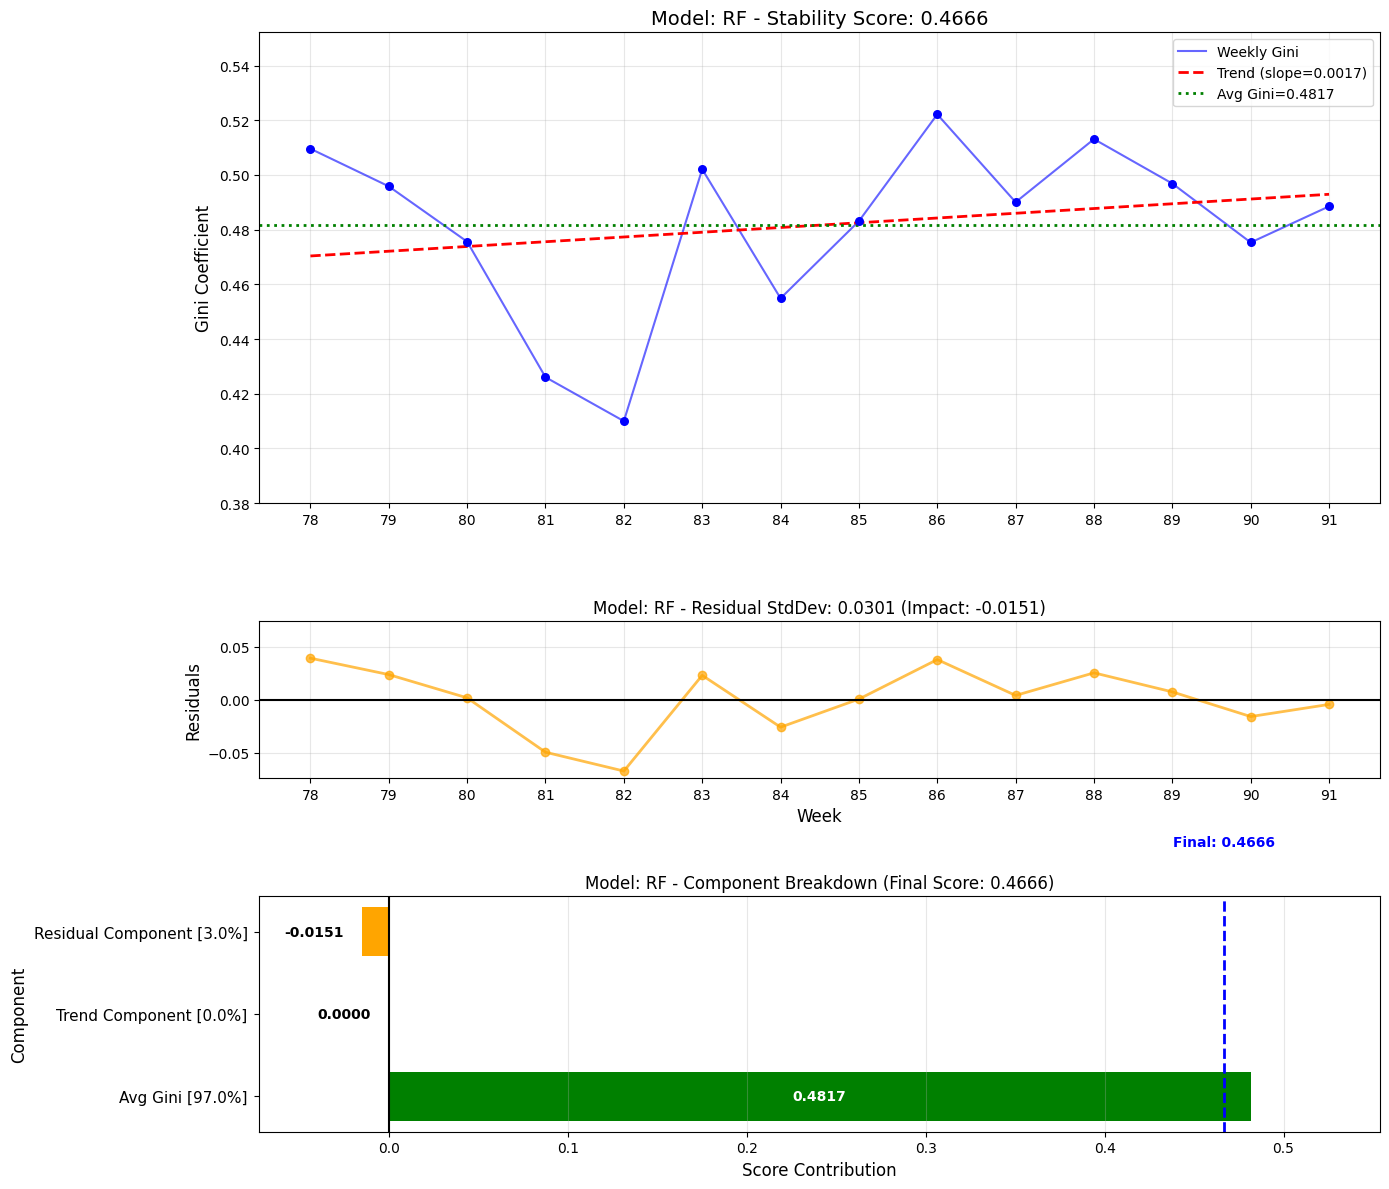

In [ ]:
weeks = range(78,92)
fig, test_residuals = plot_stability_decomposition("RF", gini_in_time_test, weeks)
plt.savefig('RF_decomposition.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
print(stability_results['stability_score'].tolist())

[-0.7075689753800406, -1.0023126455368125, -1.9120170513592882, -1.9084330179055493, -0.41410877748420716, -0.2314260295063935, 0.1109267185675211, 0.4574884171708302, 0.45981371218085687, 0.46351297243506623, 0.46560995987564757, 0.46549790970448707, 0.46657837545807157]


In [ ]:
gini_in_time_test

[0.509593303274648,
 0.4958400571881545,
 0.47561078463380113,
 0.42602853108719985,
 0.409972136404823,
 0.5020867678802965,
 0.4548741403160128,
 0.48312120369743883,
 0.5221644378113992,
 0.49004415145943225,
 0.5131094863694137,
 0.4968520197257362,
 0.4753025026447264,
 0.4885104934782998]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

def plot_cumulative_min_slope(base):
    # Get Gini coefficients by week
    gini_by_week = base.loc[:, ["WEEK_NUM", "target", "score"]]\
        .sort_values("WEEK_NUM")\
        .groupby("WEEK_NUM")[["target", "score"]]\
        .apply(lambda x: 2*roc_auc_score(x["target"], x["score"])-1).tolist()

    weeks = sorted(base["WEEK_NUM"].unique())
    min_slopes = []

    # Calculate cumulative min(0, slope) for each week
    for i in range(1, len(weeks)):
        x = np.arange(i + 1)
        y = gini_by_week[:i + 1]
        a, b = np.polyfit(x, y, 1)
        min_slopes.append(min(0, a))

    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(weeks[1:], min_slopes, 'o-')
    plt.xlabel('Week')
    plt.ylabel('min(0, a)')
    plt.title('min(0, a) by Week - RF')
    plt.grid(True)
    plt.show()

    return min_slopes


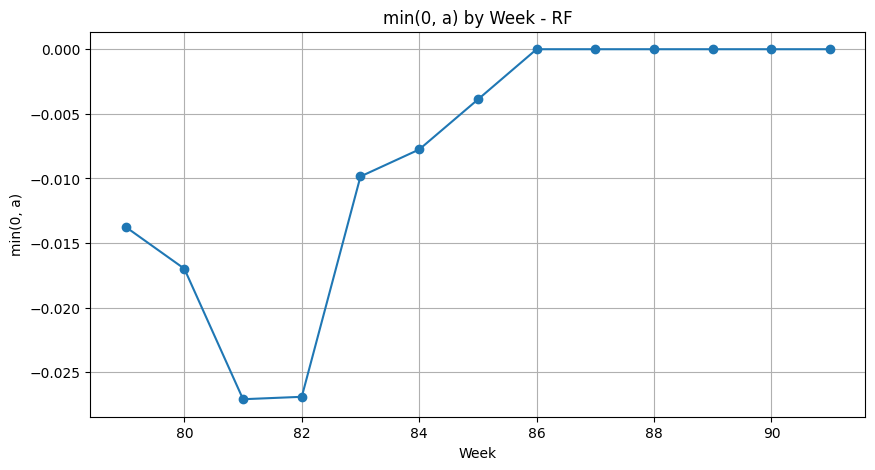

In [ ]:
min_slopes = plot_cumulative_min_slope(base_test)

In [ ]:
clean_slopes = [float(x) for x in min_slopes]
clean_slopes

[-0.013753246086493656,
 -0.016991259320423325,
 -0.02709235891166983,
 -0.026905385984060504,
 -0.009849105510524363,
 -0.007760811275735687,
 -0.0038900324564769555,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [ ]:
test_residuals

array([ 0.03922242,  0.02373382,  0.00176918, -0.04954843, -0.06734018,
        0.02303909, -0.0259089 ,  0.00060281,  0.03791068,  0.00405504,
        0.02538501,  0.00739219, -0.01589269, -0.00442006])